## Some stats and graph about Airbnb presence in Bologna, Italy. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

### I'm going to use the Inside Airbnb's data (http://insideairbnb.com/ by Murray Cox) and some older data scraped by Tom Slee (http://tomslee.net/category/airbnb-data). I will mainly use pandas package, then matplotlib and seaborn for visualization. 

### As first, I'm going to take all my csv files, doing easy pre-processing and make them consistent. Of course, using only Inside Airbnb data should make this process less annoying.

In [2]:
# all my csv! Folder name: "listings". Format of csv name: 4_2021.csv (month_year)

files = [i for i in os.listdir('listings') if i.endswith('.csv')]


# Initializing all csv files as a pandas dataframe
def setup(datalist):
    
    dfs = []
    for i in datalist:  
        try:
            dfs.append(pd.read_csv("listings/" + str(i)))
        except UnicodeDecodeError:
            print(i)
    
    return dfs     

dfs = setup(files)

# Normalizing column spelling across different dataframes    
for df in dfs:
    if "neighborhood" in df.columns:
        df["neighbourhood"] = df.neighborhood
        del df["neighborhood"]
        

# Creating a list of pandas datetimes from the filenames 
def timestamps(datalist):
    periods = []
    for i in datalist:
        y = i.split(".")[0].split("_")[1]
        m = i.split(".")[0].split("_")[0]
        d = 1
        date = str(y) + "-" + str(m) + "-" + str(d)
        date = pd.Timestamp(date)
        periods.append(date)
    return periods

periods = timestamps(files)


# Sorting dataframes by date
tmp = [(d,p) for d,p in sorted(zip(dfs,periods), key=lambda pair: pair[1])]
periods = [b for a,b in tmp]
dfs = [a for a,b in tmp]
    
    
## then check out if everything went well 
assert(len(periods) == len(dfs))

### Let's make an overview on hosts number in each dataset. The global number of hosts and announces has grown over years, in conjuction with the mean of announces per host and the standard deviation. But then, on April 2020, we can observe a breakdown due to Covid crisis: since that time, hosts and announces have stopped growing, but the concentration remains high. 

In [3]:
def overview_hosts_ids(dataset, data):
    try:
        print(f'Host statistics on {data}:')
        print(dataset['host_id'].value_counts().describe())
        print(f"Global nb of announces: {dataset['id'].count()}")
        print()
    except:
        pass

# I print just a few datasets for brevity
for i,df in enumerate(dfs[20:]):
    overview_hosts_ids(df, periods[20:][i])#.strftime('%Y/%m'))

Host statistics on 2020-01-01 00:00:00:
count    2726.000000
mean        1.623258
std         2.577538
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        69.000000
Name: host_id, dtype: float64
Global nb of announces: 4425

Host statistics on 2020-02-01 00:00:00:
count    2771.000000
mean        1.624684
std         2.572534
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        69.000000
Name: host_id, dtype: float64
Global nb of announces: 4502

Host statistics on 2020-04-01 00:00:00:
count    2345.000000
mean        1.639659
std         2.595325
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        65.000000
Name: host_id, dtype: float64
Global nb of announces: 3845

Host statistics on 2020-05-01 00:00:00:
count    2377.000000
mean        1.647875
std         2.600851
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      

### Before the lockdown, multihosts (hosts with more than one announce on Airbnb) tended to increase over time, whereas single-hosts were decreasing. Besides, the standard deviation trend make me think that the augmentation especially involves those hosts who have 2,3 or 4 announces, rather than the very big players (people with more than 10 announces).

### Let's do a lineplot to visualize general trends over time. As first, we're going to check out the growth of host/announce number, against the announces of private/shared rooms.

/home/laszlo/my_venv/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


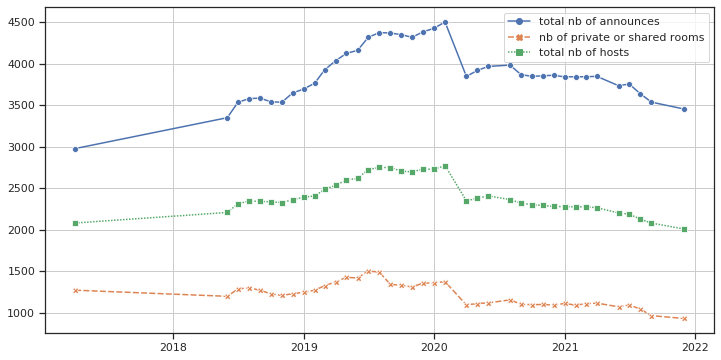

In [4]:
def snsplot(lines):
    sns.set(style="ticks")
    plt.figure(figsize=(12,6))
    sns.lineplot(markers=True, dashes=True, data=lines)
    plt.grid()


def ids_during_time(dfs, periods):
    index = pd.DatetimeIndex(periods)

    id_count = pd.Series([dfs[i].id.count() for i in range(len(dfs))], index=index)
    private_room_count = pd.Series([dfs[i][dfs[i].room_type.isin(["Private room", "Shared room"])].id.count() for i in range(len(dfs))], index=index)
    host_count = pd.Series([len(set(dfs[i].host_id)) for i in range(len(dfs))], index=index)
    
    a = "total nb of announces"
    b = "nb of private or shared rooms"
    c = "total nb of hosts"
    
    lines = id_count.rename(a).to_frame()\
        .join(private_room_count.rename(b).to_frame())\
        .join(host_count.rename(c).to_frame())
    
    snsplot(lines)

    
ids_during_time(dfs, periods)

### It's easy to notice that the growth trend it's way lower for the private / shared rooms announces, compared to the entire apartment / home announces. Let's do a focus on that:

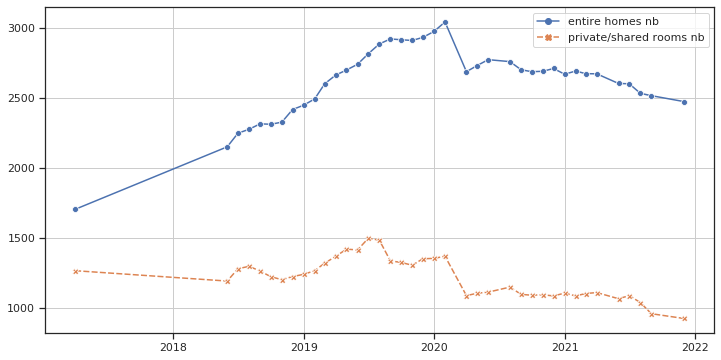

In [5]:
def type_of_room_during_time(dfs, periods):
    index = pd.DatetimeIndex(periods)

    entire_home_count = pd.Series([dfs[i][dfs[i].room_type.isin(["Entire home/apt"])].id.count() for i in range(len(dfs))], index=index)
    private_room_count = pd.Series([dfs[i][dfs[i].room_type.isin(["Private room", "Shared room"])].id.count() for i in range(len(dfs))], index=index)

    lines = entire_home_count.rename("entire homes nb").to_frame()\
        .join(private_room_count.rename("private/shared rooms nb").to_frame())
    
    snsplot(lines)


type_of_room_during_time(dfs, periods)

### Here below I removed 2016 / 2017 data so that we can begin the plot from July 2018 -  when Inside Airbnb started doing regular uploads of Bologna's data. 

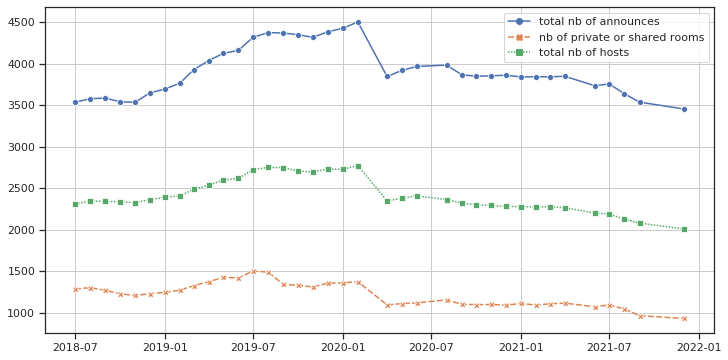

In [6]:
for i in range(2):
    periods.pop(0)
    dfs.pop(0)

ids_during_time(dfs, periods)

### Announces of entire apartments or houses have a stronger impact on city demography, since that means that those houses are entirely dedicated to tourism (there's no inhabitant living there), and they are taken off from real estate market.

### Looking carefully at data, we can notice that not all the announces are active on the platform: plenty of them have no recent review or no review at all (they've probably been uploaded shortly before the Inside Airbnb 'photo'). I tried to take this announces off (choosing a threshold of 6 months for the last review) and voilà: 

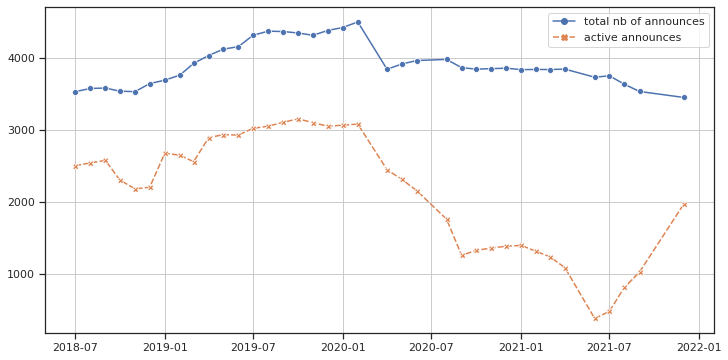

In [7]:
# transforming column 'last_review' in pandas datetimes objects 
for df in dfs:
    df['last_review'] = df['last_review'].astype('datetime64[ns]')
    
    
def active_announces(d, i, periods=periods):  
    threshold =  periods[i] - pd.DateOffset(months=6)
    idCount_oldreviews = d[d.last_review < threshold]
    idCount_inactive = d[d.number_of_reviews == 0]
    return (len(d) - (len(idCount_oldreviews) + len(idCount_inactive)))

index = pd.DatetimeIndex(periods)

idCount_total = pd.Series([df.id.count() for df in dfs], index=index)
idCount_active = pd.Series([active_announces(df, i) for i, df in enumerate(dfs)], index=index)

lines = idCount_total.rename("total nb of announces").to_frame()\
        .join(idCount_active.rename("active announces").to_frame())

snsplot(lines)

### It turns out that global number of announces is way overestimated. However, our criterion to select active announces relies on reviews, which is quite approximate: not all users leave a review after a stay. In this case, the total number of active announces is probably slightly higher. 
### While I've no clue of why there's a bending between September 2018 and January 2019, It's quite evident that the lockdown was the reason of such inactivity after April 2020. 

### Let's analyse prices. As first, I thought to remove outliers, namely those prices that seem too far from the average prices. Down here we can see some example, under the column 'price':

In [8]:
dfs[-1].sort_values(ascending=False, by=['price']).head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
3141,50742758,Blue and cozy apartment-via acri,410062989,Monica,NaN,Santo Stefano,44.49658,11.35247,Entire home/apt,9999,2,1,2021-09-01,0.28,1,116,1,NaN
240,4647054,CHARMING FLAT IN HISTORICAL CENTER,24058338,Mauro,NaN,Porto - Saragozza,44.49939,11.34116,Entire home/apt,9999,2,16,2017-07-05,0.19,1,37,0,NaN
3402,53350173,Falegnami Suites- Studio Apartment,49812442,Rambaldo,NaN,Porto - Saragozza,44.49953,11.34170,Entire home/apt,5000,1,0,NaT,NaN,17,365,0,NaN
2367,39690694,FlatinBO apartments Stazione Centrale- L. Costa,50429991,Flat In Italy,NaN,Navile,44.50984,11.34412,Entire home/apt,5000,1,3,2020-02-19,0.12,11,259,0,NaN
2555,41814033,Giardini Margherita apartments - Flat in Italy,50429991,Flat In Italy,NaN,Santo Stefano,44.48462,11.34745,Entire home/apt,2000,1,2,2020-02-16,0.09,11,0,0,NaN


### 9999 euros seems to be an inconsistent price, ok. But what about 5000? Could it be an informal price per month? If so, do they deposit a regular rent contract? Is there any economical benefit to rent a house monthly through Airbnb instead of using traditional channels? Something to look into... 

### Let's remove the outliers. I weight the price with the number of days in which the announce is available, then I exclude the ones that fall off the 98° percentile.

In [9]:
def remove_outliers(period):
    x = period['price'] * period['availability_365'] / 365
    period["price_pond"] = x
    y = period['price']
    return period[y.between(y.quantile(.0001), y.quantile(.98))]

dfs = [remove_outliers(i) for i in dfs]


# formatting datetimes for better captions...

periods_2 = [i.strftime('%Y/%m') for i in periods]

### The next 2 charts show the gap between the biggest players (the top 5 % of hosts with more announces) and those with a single announce (about three quarters of total users). The host-announce distribution draws a sort of zipf curve: very few hosts with a lot of announces, and a long tail of unique-announce hosts. 

In [10]:
def three_val1(dfs=dfs):
    return (0, round(len(dfs) / 2), -3)

def three_val2(dfs=dfs):
    start = round(len(dfs) / 2)
    return (start, round(start / 2), -2)

def three_val3(dfs=dfs):
    start = round(len(dfs) / 4)*3
    return (start, round(start / 2), -1)


def single_host(period):
    
        a = period[period.calculated_host_listings_count == 1]

        percentIncomes = a.price.sum() * 100 / period.price.sum()
        percentAnnounces = a.id.count() * 100 / period.id.count()
        percentHost = len(a.host_id.value_counts()) * 100 / len(period.host_id.value_counts())
        
        return pd.Series([percentHost, percentAnnounces, percentIncomes])

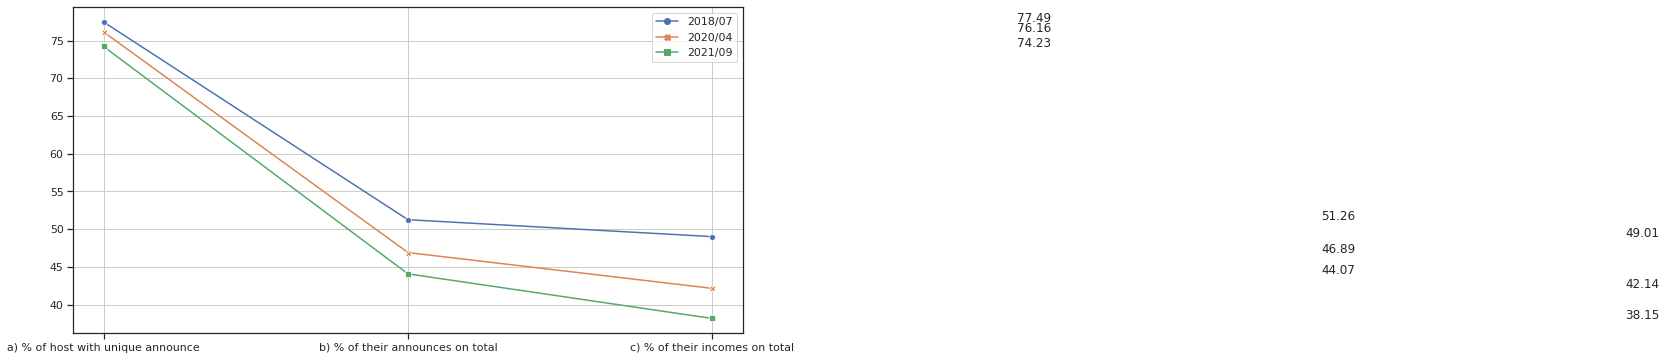

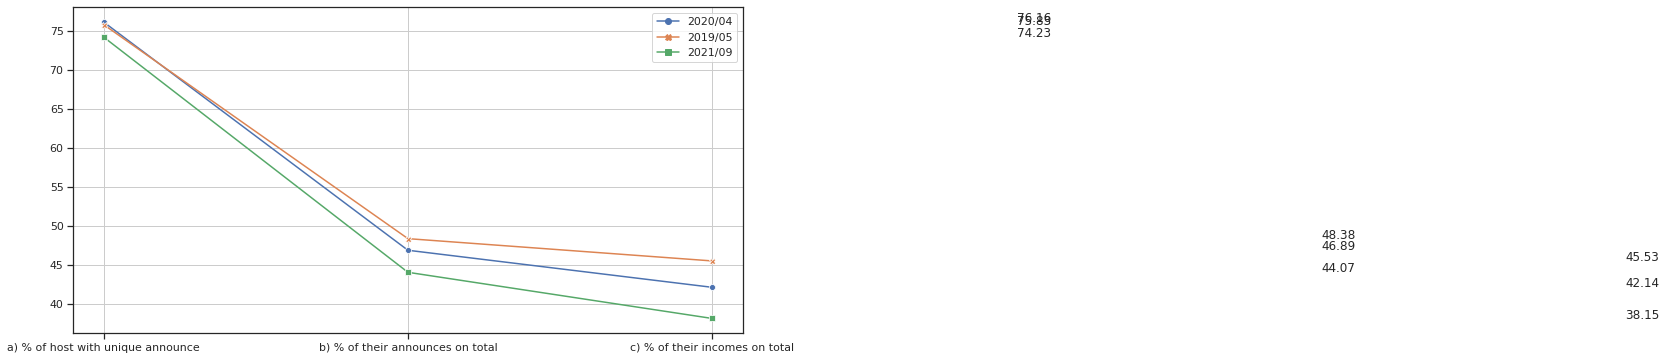

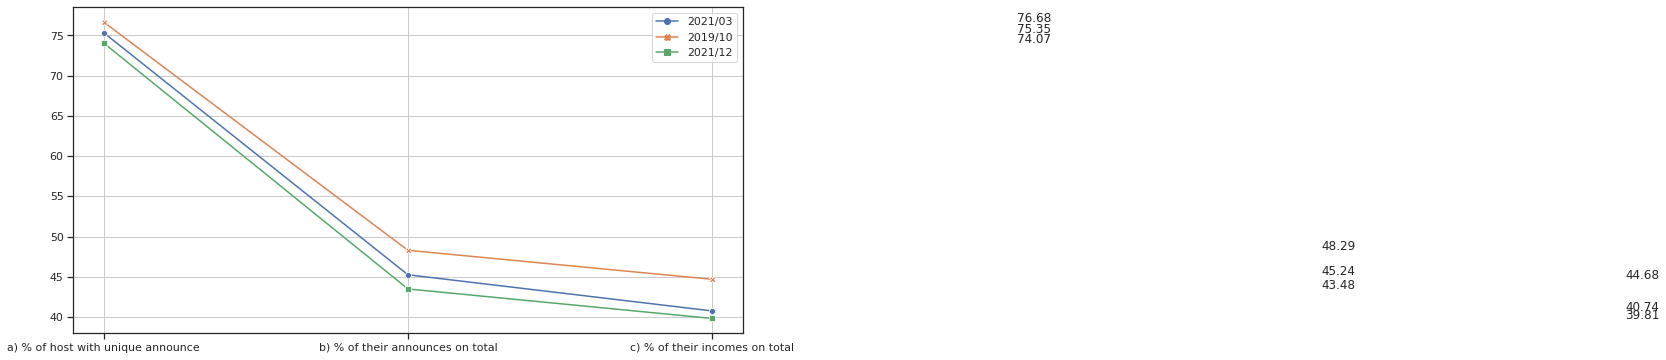

In [11]:
def scissor_1(thrval, periods=periods_2):
    
    a = []
    for i in thrval:
        a.append(single_host(dfs[i]))
    
    x = pd.Series(["a) % of host with unique announce","b) % of their announces on total","c) % of their incomes on total"])
    
    plotting(a,thrval,x)
    
def plotting(a,thrval,x,periods=periods_2):
    
        lines = a[0].rename(periods[thrval[0]]).to_frame()\
        .join(a[1].rename(periods[thrval[1]]).to_frame())\
        .join(a[2].rename(periods[thrval[2]]).to_frame()).set_index(x)
    
        snsplot2(lines)
        
def snsplot2(lines):
    
    l = lines.T
    sns.set(style="ticks")
    dims = (12, 6)
    
    fig, ax = plt.subplots(1,1,figsize=dims)
    
    sns.lineplot(markers=True, dashes=False, data=lines)
    plt.grid()
    
    for ix,time in enumerate(l.index):
   
        ax.text(l.index[ix], l[l.columns[ix]][0], f'{l[l.columns[ix]][0]:.2f}')
        ax.text(l.index[ix], l[l.columns[ix]][1], f'{l[l.columns[ix]][1]:.2f}')
        ax.text(l.index[ix], l[l.columns[ix]][2], f'{l[l.columns[ix]][2]:.2f}')
        

    
i = scissor_1(three_val1())
ii = scissor_1(three_val2())
iii = scissor_1(three_val3())

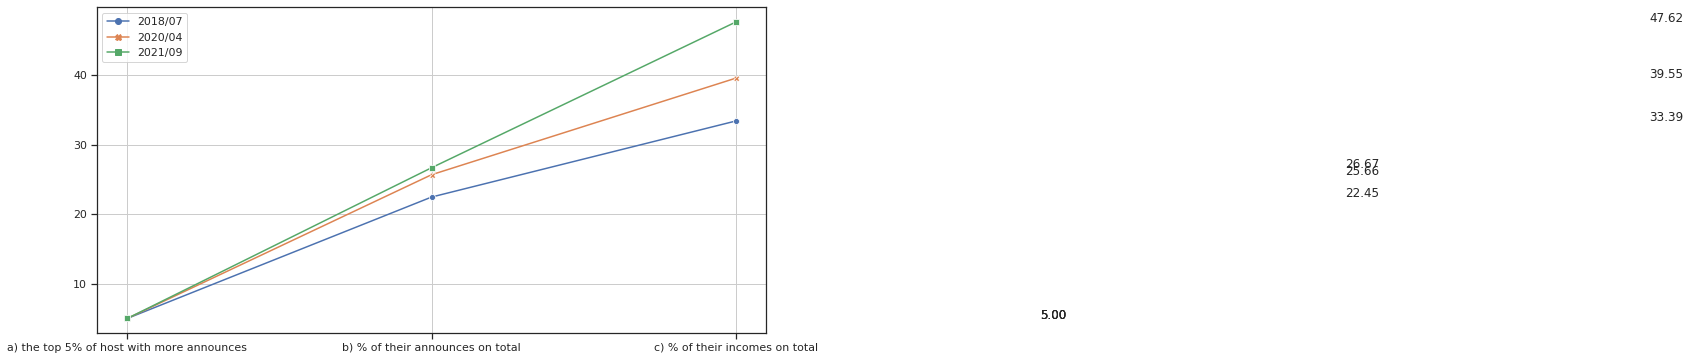

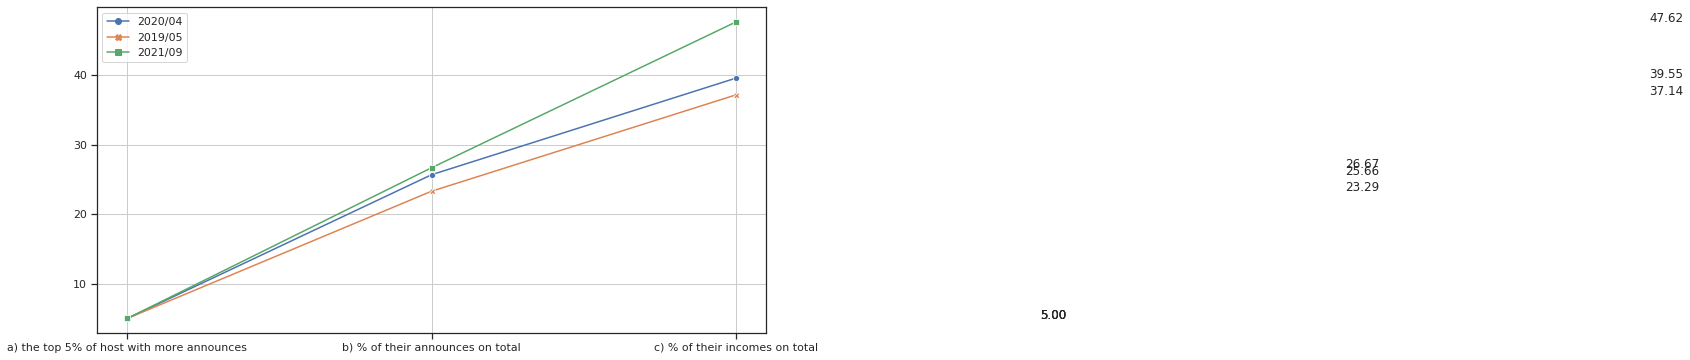

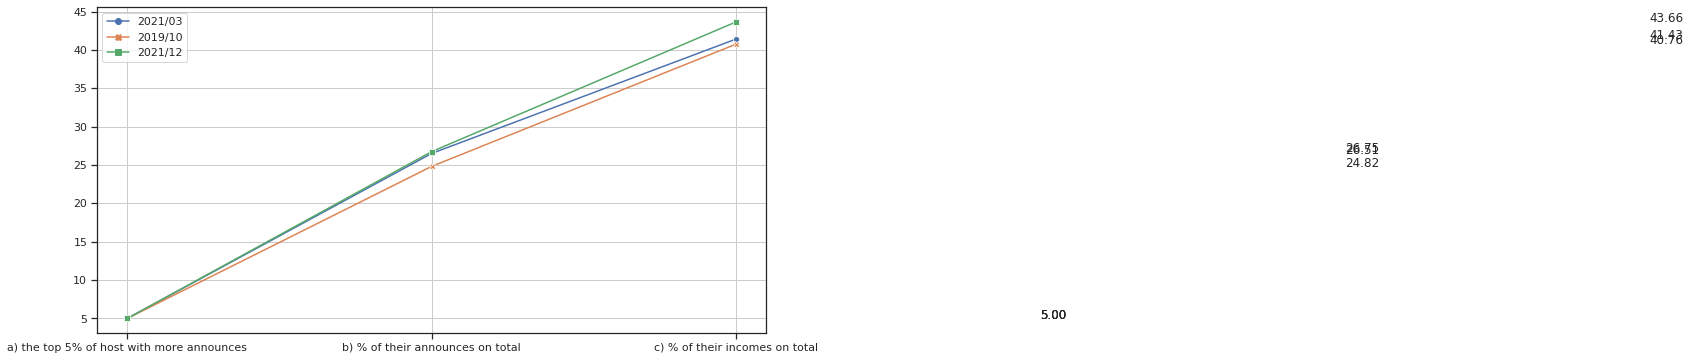

In [12]:
def incomes_rate(period, nHosts):
    
    g = period.groupby("host_id")['price_pond'].sum().sort_values(ascending=False)
    h = period.groupby("host_id")['id'].count().sort_values(ascending=False)
    
    percentAnnounces = h[:nHosts].sum() * 100 / period.id.count()
    percentIncomes = g[:nHosts].sum() * 100 / g.sum()
    
    return pd.Series([5, percentAnnounces, percentIncomes])

def five_percent(period):          
    return int(round(len(period["host_id"].value_counts()) / 20))

def scissor_2(thrval, periods=periods_2):
    
    a = []
    for i in thrval:
        a.append(incomes_rate(dfs[i], five_percent(dfs[i])))


    x = pd.Series(["a) the top 5% of host with more announces", "b) % of their announces on total" ,"c) % of their incomes on total"])

    plotting(a,thrval,x)
    
scissor_2(three_val1())
scissor_2(three_val2())
scissor_2(three_val3())

### This is one of the few trends that is even corroborated after the lockdown: announces and incomes tend to be concentrated over time.

### Next, a couple of barplots that show prices and announces count trends over time per neighbourhood.

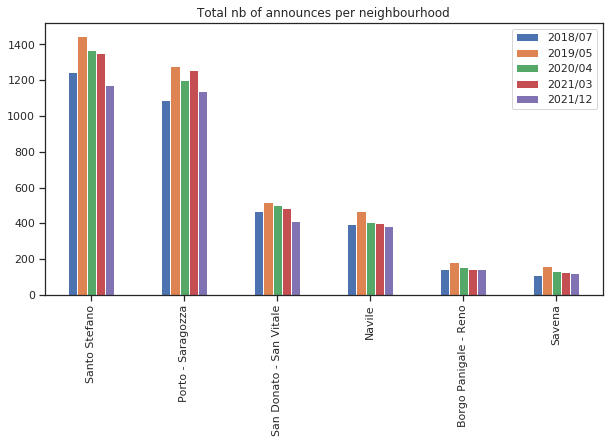

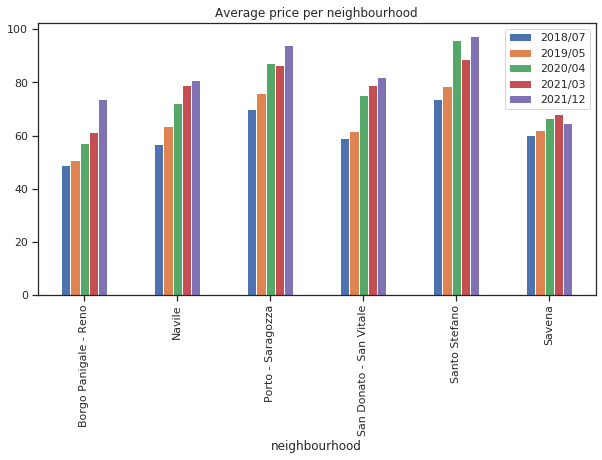

In [13]:
def five_val(dfs=dfs):
    median = round(len(dfs) / 2)
    second = round(round(len(dfs) / 2) / 2)
    fourth = median + second
    return [0, second, median, fourth, -1]

def plotting(series, title, i=five_val(), dfs=dfs, periods=periods_2):
    
    graph_df = series[0].rename(periods[i[0]]).to_frame()\
    .join(series[1].rename(periods[i[1]]).to_frame())\
    .join(series[2].rename(periods[i[2]]).to_frame())\
    .join(series[3].rename(periods[i[3]]).to_frame())\
    .join(series[4].rename(periods[i[4]]).to_frame())
    graph_df.plot(kind='bar',figsize=(10, 5), title=title)
    
def neigh_id_count(ils=five_val(), dfs=dfs):
    return [dfs[i]['neighbourhood'].value_counts(normalize=False) for i in ils]

def neigh_average_price(ils=five_val(), dfs=dfs):
    return [dfs[i].groupby("neighbourhood")['price'].mean() for i in ils]
        

plotting(neigh_id_count(), "Total nb of announces per neighbourhood")
plotting(neigh_average_price(), "Average price per neighbourhood")

### And that's all for now! Please feel free to write me in case you find any relevant flaw in statistics. I really hope someone find this code useful to study Airbnb across other cities. Ciao!
